# Meta-learning classification features: Model

**Imports**

In [1]:
# imports

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

**Classification model**

In [2]:
class ClassificationModel():

    def __init__(self, target_label):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]

        self.target_label = target_label
        self.dataset = self.load_dataset()
        self.x_train, self.x_test, self.y_train, self.y_test = self.create_train_test_data()
        self.measures = {}
        self.feature_importances = pd.Series()
        self.run(self.all_features)

    def load_dataset(self):

        dataset = pd.read_csv("samples_0_6935_all_defects.csv", sep = ",")
        dataset.drop(columns = ["Unnamed: 0", "image_number", "defect_number"], inplace = True)
        dataset.dropna(inplace = True)

        return dataset
    
    def create_train_test_data(self):

        # Create rust labels:
        target_class_df = self.dataset.copy()
        target_class_df["target_label"] = target_class_df["label"].apply(lambda x: 1 if x == self.target_label else 0)

        # Apply train test split:
        target_class_df = target_class_df.sort_values(by = "target_label", ascending = False)
        number_of_defects = target_class_df["target_label"].sum()
        target_class_df_1 = target_class_df.iloc[:number_of_defects, :]
        negative_samples = random.sample(range(number_of_defects, len(target_class_df)), number_of_defects)
        target_class_df_0 = target_class_df.iloc[negative_samples, :]
        df = pd.concat([target_class_df_1, target_class_df_0], ignore_index=True)
        x = df.loc[:, self.all_features]
        y = df.loc[:, "target_label"]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

        return x_train, x_test, y_train, y_test

    def select_features(self, features):

        x_train = self.x_train.loc[:, features]
        x_test = self.x_test.loc[:, features]

        return x_train, x_test
    
    def evaluate(self, y_pred):

        accuracy = accuracy_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred, average=None)[1]
        f1 = f1_score(self.y_test, y_pred, average=None)[1]

        return accuracy, recall, f1
    
    def run(self, features, number_of_forests=1):

        # Check whether feature combination already exists in measures dictionary:
        feature_combination = ", ".join(sorted(features))
        if feature_combination in self.measures:
            accuracy, recall, f1 = self.measures[feature_combination]
            current_feature_importances = self.feature_importances
        else:

            # Generate train dataset with selected features: 
            x_train, x_test = self.select_features(features)

            # Perform the random forest classifier: 
            for i in range(number_of_forests):
                clf = RandomForestClassifier(n_estimators=50, criterion= "entropy", random_state=i, max_depth=10)
                clf.fit(x_train, self.y_train)
                y_pred = clf.predict(x_test)
                if i == 0:
                    y_pred_final = y_pred
                else:
                    y_pred_final = np.array([1 if y_pred[i] == 1 or y_pred_final[i] == 1 else 0 for i in range(len(y_pred))])

            # Evaluate and store results:
            accuracy, recall, f1 = self.evaluate(y_pred_final)
            current_feature_importances = clf.feature_importances_
            feature_names = x_train.columns
            current_feature_importances = pd.Series(current_feature_importances, index=feature_names)
            
            #print(type(current_feature_importances))
            #print(current_feature_importances)
            
            self.measures[feature_combination] = (accuracy, recall, f1)
            for feature in current_feature_importances.index:
                self.feature_importances.loc[feature] = current_feature_importances.loc[feature]

        print(f"Feature set: {features}, \nAccuracy: {accuracy}, \nRecall: {recall},\nF1: {f1}\n")
        return f1, current_feature_importances



**Environment**

In [3]:
class State():

    def __init__(self, state, action=None):

        if not action == None:
            state = self.bitflip(state, action)

        self.binary = state.float()

    def bitflip(self, state, action):

        adjusted_state = state.binary.clone()

        for index in action:
            if state.binary[index] == 0:
                adjusted_state[index] = 1
            else:
                adjusted_state[index] = 0

        return adjusted_state


class Dacl10kEnvironment():

    def __init__(self, classifier, initial_state=None):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]
        
        self.classifier = classifier
        self.features_dict = {i: feature for i, feature in enumerate(self.all_features)}
        self.statesize = len(self.all_features)

        _, current_feature_importances = self.classifier.run(self.all_features)
        self.feature_importances = current_feature_importances

        self.initial_state = State(torch.FloatTensor([i % 2 for i in range(len(self.all_features))])) if initial_state == None else initial_state
        self.state = self.initial_state

        self.table = {}

    def step(self, action):

        next_state = State(self.state, action)
        self.state = next_state

        features_indices = [i for i, value in enumerate(self.state.binary.numpy()) if value == 1]
        features = [self.features_dict[i] for i in features_indices]
        reward, current_feature_importances = self.classifier.run(features)
        self.table[tuple([self.features_dict[i] for i, binary in enumerate(tuple(self.state.binary.detach().numpy())) if binary == 1])] = reward
        for feature in current_feature_importances.index:
            self.feature_importances.loc[feature] = current_feature_importances.loc[feature]
        #print(self.feature_importances)

        return next_state, reward


**Reinforcement Agent**

In [4]:
class FeedforwardNet(nn.Module):

    def __init__(self, env, device, hidden_size):

        super(FeedforwardNet, self).__init__()
        
        self.device = device
        self.statesize = env.statesize
        self.hidden_size = hidden_size
        
        self.hidden_layer = nn.Linear(self.statesize, self.hidden_size).to(self.device)
        self.output_layer = nn.Linear(self.hidden_size, self.statesize).to(self.device)
        self.sigmoid = nn.Sigmoid().to(self.device)

    def forward(self, input):

        x = self.hidden_layer(input)
        x = torch.relu(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)

        return x


class ReinforcementAgent():

    def __init__(self, env):

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = FeedforwardNet(env, self.device, 50)

        self.optimizer = torch.optim.Adam(self.net.parameters(),lr=0.01)

        self.exploration_chance = 0.05
        self.statesize = env.statesize

    def step(self, state, feature_importances):

        probabilities = self.net.forward(feature_importances)
        #print(probabilities)
        probability_differences = torch.abs(state.binary - probabilities)
        _, action = torch.topk(probability_differences, random.randint(5, 15))
        action = action.tolist()

        """
        # Exploration adjustments:
        for i, _ in enumerate(action):
            if random.random() < self.exploration_chance:
                action[i] = random.randint(0, self.statesize - 1)
        """

        # Exploration adjustements:
        for i in range(self.statesize):
            if random.random() < self.exploration_chance and i not in action:
                action.append(i)

        # If no feature remaining in action, include highest likelihood features
        if torch.sum(State(state, action).binary).item() < 1:
            action = None

        return action

    def update(self, reward):

        reward = torch.tensor(reward, dtype=torch.float32, requires_grad=True)
        #loss = -torch.log(reward)
        loss = torch.sqrt(1 - reward)
        #print(f"Loss: {loss}")

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



**Train the reinforcement agent**

In [5]:
def plot_rewards(rewards):

    x = list(range(len(rewards)))

    moving_average_rewards = []
    window_size = 50
    for i in range(len(rewards)):
        start_index = max(0, i - window_size + 1)
        window = rewards[start_index:i + 1]
        moving_average_rewards.append(sum(window) / len(window))

    plt.figure(figsize=(10, 5))
    plt.plot(x, rewards, marker="o", linestyle="-", color="b")
    plt.plot(x, moving_average_rewards, linestyle="-", color="r")

    plt.title("Rewards")
    plt.xlabel("Epoch")
    plt.ylabel("Reward")
    plt.grid(True)

    plt.show()

def train_agent(classifier, initial_features=None, epochs=500):

    # Initialize variables:
    env = Dacl10kEnvironment(classifier)
    agent = ReinforcementAgent(env)

    state = env.initial_state
    rewards = []

    # Prepare initial state:
    if not initial_features == None:
        initial_state = State(torch.FloatTensor([feature in initial_features for feature in env.all_features]))
        env = Dacl10kEnvironment(classifier, initial_state=initial_state)

    # Run epochs:
    for i in range(epochs): 

        print(f"Epoch {i}")
        
        action = agent.step(state, torch.FloatTensor(env.feature_importances.loc[:]))
        #print(action)
        next_state, reward = env.step(action)
        agent.update(reward)
        state = next_state

        print(f"Reward: {reward}\n")
        rewards.append(reward)

    # Evaluate results:
    plot_rewards(rewards)
    best_feature_set = max(env.table, key=lambda k: env.table[k])
    print(f"Best Feature set: {best_feature_set}\nReward: {env.table[best_feature_set]}\n")

def random_monkey(classifier, repetitions=500):

    # Initialize variables:
    env = Dacl10kEnvironment(classifier)
    rewards = []

    # Run repetitions:
    for i in range(repetitions):

        print(f"Repitition {i}")
        
        random_binary = random.choices([0, 1], k=44)
        features_indices = [i for i, value in enumerate(random_binary) if value == 1]
        features = [env.features_dict[i] for i in features_indices]
        reward = classifier.run(features)
        rewards.append(reward)
        env.table[tuple([env.features_dict[i] for i, binary in enumerate(random_binary) if binary == 1])] = reward
    
    # Evaluate results:
    plot_rewards(rewards)
    best_feature_set = max(env.table, key=lambda k: env.table[k])
    print(f"Best Feature set: {best_feature_set}\nReward: {env.table[best_feature_set]}\n")


**Cross-evaluation of the classifiers**

In [19]:
class CrossEvaluation():

    def __init__(self, relevant_features):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]

        self.relevant_features = relevant_features
        self.dataset = self.load_dataset()
        self.dataset_train, self.dataset_test = self.create_train_test_data()
        self.classifiers, self.predictions = {}, {}

        for defect in self.relevant_features.keys():
            self.classifiers[defect] = self.initialize_trees(defect)
            self.predictions[defect] = self.predict_binary(defect)
        
        self.predictions = pd.DataFrame(self.predictions)
        self.results = pd.concat([self.predictions.reset_index(drop=True), 
                                  self.predict_label().reset_index(drop=True), 
                                  self.dataset_test["label"].reset_index(drop=True)], axis=1)

        self.evaluate_results()
        
    
    def load_dataset(self):

        dataset = pd.read_csv("samples_0_6935_all_defects.csv", sep = ",")
        dataset.drop(columns = ["Unnamed: 0", "image_number", "defect_number"], inplace = True)
        dataset.dropna(inplace = True)
        dataset = dataset.sample(frac=1)

        return dataset
    
    def create_train_test_data(self):

        split = int(0.7 * len(self.dataset))
        dataset_train = self.dataset.iloc[:split, :]
        dataset_test = self.dataset.iloc[split:, :]

        return dataset_train, dataset_test
    
    def select_features(self, features, x):

        x = x.loc[:, features]

        return x

    def create_labelled_data(self, defect):

        # Create target labels:
        target_class_df = self.dataset_train.copy()
        target_class_df["target_label"] = target_class_df["label"].apply(lambda x: 1 if x == defect else 0)

        # Apply train test split:
        target_class_df = target_class_df.sort_values(by = "target_label", ascending = False)
        number_of_defects = target_class_df["target_label"].sum()
        target_class_df_1 = target_class_df.iloc[:number_of_defects, :]
        negative_samples = random.sample(range(number_of_defects, len(target_class_df)), number_of_defects)
        target_class_df_0 = target_class_df.iloc[negative_samples, :]
        df = pd.concat([target_class_df_1, target_class_df_0], ignore_index=True)
        x_train = df.loc[:, self.all_features]
        y_train = df.loc[:, "target_label"]

        return x_train, y_train

    def initialize_trees(self, defect):

        # Create dataset with binary labels:
        x_train, y_train, = self.create_labelled_data(defect)

        # Generate train dataset with selected features: 
        x_train = self.select_features(self.relevant_features[defect], x_train)

        clf = RandomForestClassifier(n_estimators=50, criterion= "entropy", random_state=1, max_depth=10)
        clf.fit(x_train, y_train)

        return clf
    
    def predict_binary(self, defect):

        x_test = self.select_features(self.relevant_features[defect], self.dataset_test)
        predictions = self.classifiers[defect].predict_proba(x_test)[:, 1]

        return predictions
    
    def predict_label(self):

        predicted_labels = {}

        for i in range(len(self.predictions)):
            count = 0
            max = 0
            max_label = None
            for j in range(self.predictions.shape[1]):
                if self.predictions.iloc[i, j] >= 0.5:
                    count += 1
                    if self.predictions.iloc[i, j] > max:
                        max = self.predictions.iloc[i, j]
                        max_label = self.predictions.columns[j]
            predicted_labels[i] = [count, max, max_label if not max_label == None else "Nothing"]
        
        predicted_labels = pd.DataFrame(predicted_labels).T
        predicted_labels.columns = ["Count", "Max", "Predicted Label"]

        return predicted_labels

    def evaluate_results(self):

        y_true = self.results["label"]
        y_pred = self.results["Predicted Label"]

        for i, _ in enumerate(y_true):
            if y_true.iloc[i] not in self.relevant_features.keys():
                y_true.iloc[i] = "Nothing"

        accuracy = accuracy_score(y_true, y_pred)
        
        recall_micro = recall_score(y_true, y_pred, average='micro')
        recall_macro = recall_score(y_true, y_pred, average='macro')
        recall_weighted = recall_score(y_true, y_pred, average='weighted')

        f1_micro = f1_score(y_true, y_pred, average='micro')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')

        print(f'Accuracy: {accuracy}')
        print(f'Recall (Micro): {recall_micro}')
        print(f'Recall (Macro): {recall_macro}')
        print(f'Recall (Weighted): {recall_weighted}')
        print(f'F1 Score (Micro): {f1_micro}')
        print(f'F1 Score (Macro): {f1_macro}')
        print(f'F1 Score (Weighted): {f1_weighted}')

        cm = confusion_matrix(y_true, y_pred, labels = sorted(list(set(y_true))))
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion Matrix:")
        print(cm)

        # Compute confusion matrix
        labels = sorted(list(set(y_true)))  # Get unique labels and sort them

        # Plotting the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')

        # Display the plot
        plt.show()

        

In [43]:
class MultilabelClassificationModel():

    def __init__(self):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]
        
        self.dataset = self.load_dataset()
        self.dataset_train, self.dataset_test = self.create_train_test_data()
        self.classifier = self.initialize_tree()
        self.y_test, self.y_pred = self.predict()

        self.evaluate_results()
        
    def load_dataset(self):

        dataset = pd.read_csv("samples_0_6935_all_defects.csv", sep = ",")
        dataset.drop(columns = ["Unnamed: 0", "image_number", "defect_number"], inplace = True)
        dataset.dropna(inplace = True)
        dataset = dataset.sample(frac=1)

        return dataset
    
    def select_features(self, features, x):

        x = x.loc[:, features]

        return x
    
    def create_train_test_data(self):

        split = int(0.7 * len(self.dataset))
        dataset_train = self.dataset.iloc[:split, :]
        dataset_test = self.dataset.iloc[split:, :]

        return dataset_train, dataset_test
    
    def create_labelled_data(self, df):

        # Create x and y train data:
        df = df.copy()
        x_train = df.loc[:, self.all_features]
        y_train = df.loc[:, "label"]

        return x_train, y_train
    
    def initialize_tree(self):

        # Create dataset with labels:
        x_train, y_train, = self.create_labelled_data(self.dataset_train)

        # Generate train dataset with selected features: 
        x_train = self.select_features(self.all_features, x_train)

        clf = RandomForestClassifier(n_estimators=50, criterion= "entropy", random_state=1, max_depth=10)
        clf.fit(x_train, y_train)

        return clf
    
    def predict(self):

        # Create dataset with labels:
        x_test, y_test = self.create_labelled_data(self.dataset_test)
        x_test = self.select_features(self.all_features, x_test)
        y_pred = self.classifier.predict(x_test)

        return y_pred, y_test
    
    def evaluate_results(self):

        y_pred, y_true = self.y_pred, self.y_test

        accuracy = accuracy_score(y_true, y_pred)
        
        recall_micro = recall_score(y_true, y_pred, average='micro')
        recall_macro = recall_score(y_true, y_pred, average='macro')
        recall_weighted = recall_score(y_true, y_pred, average='weighted')

        f1_micro = f1_score(y_true, y_pred, average='micro')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')

        print(f'Accuracy: {accuracy}')
        print(f'Recall (Micro): {recall_micro}')
        print(f'Recall (Macro): {recall_macro}')
        print(f'Recall (Weighted): {recall_weighted}')
        print(f'F1 Score (Micro): {f1_micro}')
        print(f'F1 Score (Macro): {f1_macro}')
        print(f'F1 Score (Weighted): {f1_weighted}')

        print(y_true)
        print(y_pred)
        cm = confusion_matrix(y_true, y_pred, labels = sorted(list(set(y_true))))
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion Matrix:")
        print(cm)

        # Compute confusion matrix
        labels = sorted(list(set(y_true)))  # Get unique labels and sort them

        # Plotting the confusion matrix as a heatmap
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')

        # Display the plot
        plt.show()

c:\Users\koeni\Documents\Programme\Python_3.11\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\koeni\Documents\Programme\Python_3.11\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3859287054409006
Recall (Micro): 0.3859287054409006
Recall (Macro): 0.31894740213917033
Recall (Weighted): 0.3859287054409006
F1 Score (Micro): 0.3859287054409006
F1 Score (Macro): 0.26193694937660084
F1 Score (Weighted): 0.40306427290613117
Confusion Matrix:
[[0.38738739 0.         0.         0.06306306 0.         0.02702703
  0.07207207 0.         0.02702703 0.04504505 0.01801802 0.01801802
  0.         0.01801802 0.         0.02702703 0.11711712 0.13513514
  0.04504505]
 [0.01006711 0.56040268 0.0033557  0.01342282 0.08724832 0.05704698
  0.00671141 0.01677852 0.01342282 0.02013423 0.02013423 0.04362416
  0.04026846 0.00671141 0.03691275 0.         0.0033557  0.03691275
  0.02348993]
 [0.02302346 0.00434405 0.66768028 0.04126846 0.01303215 0.00651607
  0.00738488 0.02562989 0.01303215 0.00999131 0.00521286 0.00564726
  0.00260643 0.03649001 0.07906169 0.03127715 0.01433536 0.00521286
  0.00825369]
 [0.09443861 0.01469045 0.03252886 0.29695698 0.01469045 0.02728227
  0.04

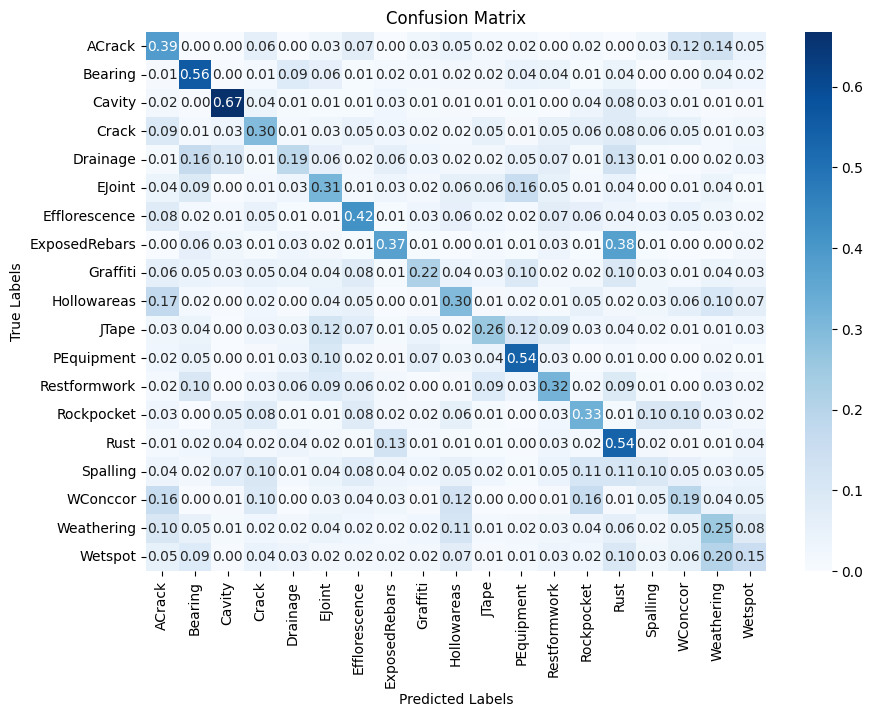

In [20]:
relevant_features = {"Rust": ['gradient', 'reddish', 'black', 'dominating_color', 'color_bin_1', 'color_bin_5', 'color_bin_6', 
                              'color_bin_7', 'color_bin_8', 'color_entropy', 'texture_0', 'texture_8', 'lengthy', 'number_lengthy_objects', 
                              'rel_length', 'roundness', 'hu_moment_2', 'hu_moment_5'],
                    "Drainage": ['gradient', 'colorful', 'black', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 
                                 'color_bin_4', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 
                                 'texture_0', 'texture_1', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'lengthy', 'roundness', 
                                 'hu_moment_1', 'hu_moment_3', 'hu_moment_7'],
                    "Graffiti": ['darker', 'reddish', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_4', 'color_bin_6', 
                                  'color_bin_8', 'color_entropy', 'rough', 'dominating_texture', 'texture_1', 'texture_2', 'texture_4', 'texture_6', 
                                  'texture_7', 'texture_9', 'rough_entropy', 'lengthy', 'lengthy_aspect_ratio', 'roundness', 'hu_moment_4'],
                    "Crack": ['reddish', 'metallic', 'colorful', 'black', 'black_thin', 'color_bin_2', 'color_bin_4', 'color_bin_6', 'color_bin_9', 
                              'color_entropy', 'texture_1', 'texture_2', 'texture_3', 'texture_5', 'lengthy', 'number_lengthy_objects', 'rel_length', 
                              'in_shape', 'hu_moment_1', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6'],
                    "ExposedRebars": ['gradient', 'reddish', 'metallic', 'black_thin', 'dominating_color', 'color_bin_4', 'color_bin_6', 
                                      'color_bin_7', 'color_bin_8', 'dominating_texture', 'texture_0', 'texture_2', 'texture_3', 'texture_5', 
                                      'texture_8', 'texture_9', 'rel_length', 'in_shape', 'roundness', 'hu_moment_2', 'hu_moment_4', 'hu_moment_7'],
                    "Wetspot": ['metallic', 'colorful', 'dominating_color', 'color_bin_6', 'color_bin_9', 'color_entropy', 'texture_1', 'texture_2', 
                                'texture_3', 'texture_6', 'texture_7', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'in_shape', 
                                'roundness', 'hu_moment_2', 'hu_moment_3', 'hu_moment_6', 'hu_moment_7'],
                    "Weathering": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "Rockpocket": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "Spalling": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "WConccor": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "Cavity": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "Efflorescence": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "PEquipment": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "Bearing": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "Hollowareas": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "JTape": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "Restformwork": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "ACrack": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"], 
                    "EJoint": ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                                   "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                                   "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                                   "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                                   "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                                   "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]
                    }

cross_evaluation = CrossEvaluation(relevant_features)



C:\Users\koeni\AppData\Local\Temp\ipykernel_19964\1322729393.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[i] = "Nothing"
C:\Users\koeni\AppData\Local\Temp\ipykernel_19964\1322729393.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[i] = "Nothing"
C:\Users\koeni\AppData\Local\Temp\ipykernel_19964\1322729393.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[i] = "Nothing"
C:\Users\koen

Accuracy: 0.30744215134459035
Recall (Micro): 0.30744215134459035
Recall (Macro): 0.45793204460467657
Recall (Weighted): 0.30744215134459035
F1 Score (Micro): 0.30744215134459035
F1 Score (Macro): 0.26947565984864125
F1 Score (Weighted): 0.3144842225137793
Confusion Matrix:
[[0.63001028 0.03391572 0.05035971 0.08221994 0.01747174 0.10585817
  0.08016444]
 [0.05141388 0.42673522 0.06940874 0.13624679 0.03084833 0.16966581
  0.11568123]
 [0.03839122 0.06581353 0.48628885 0.01462523 0.         0.36928702
  0.02559415]
 [0.13240418 0.13066202 0.01916376 0.43205575 0.0174216  0.09581882
  0.17247387]
 [0.2513632  0.11910617 0.03442746 0.13899284 0.13546456 0.11343954
  0.20720624]
 [0.06071142 0.07194437 0.16474993 0.02647767 0.02861728 0.5720781
  0.07542124]
 [0.14457831 0.0939759  0.03614458 0.07710843 0.01686747 0.10843373
  0.52289157]]


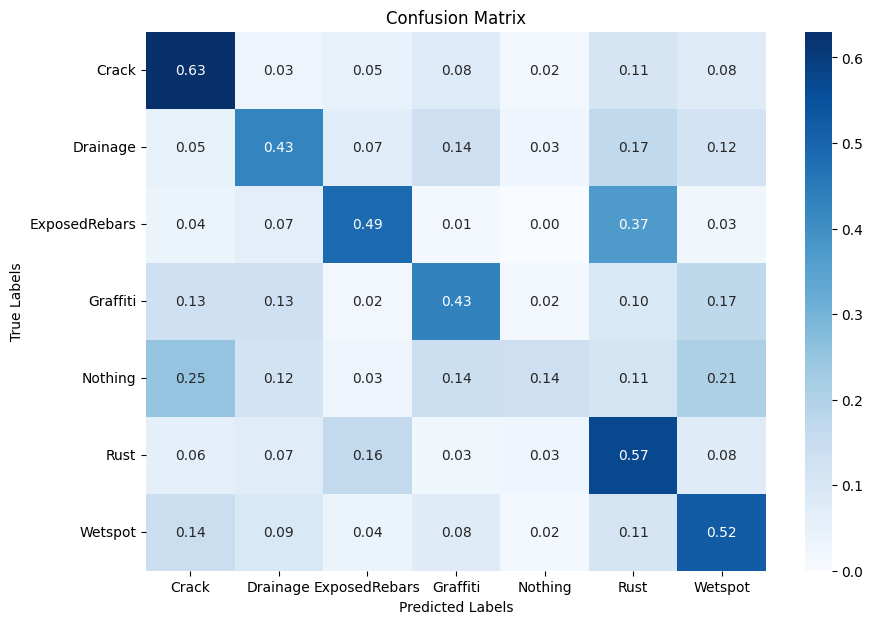

In [22]:
relevant_features = {"Rust": ['gradient', 'reddish', 'black', 'dominating_color', 'color_bin_1', 'color_bin_5', 'color_bin_6', 
                              'color_bin_7', 'color_bin_8', 'color_entropy', 'texture_0', 'texture_8', 'lengthy', 'number_lengthy_objects', 
                              'rel_length', 'roundness', 'hu_moment_2', 'hu_moment_5'],
                    "Drainage": ['gradient', 'colorful', 'black', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 
                                 'color_bin_4', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 
                                 'texture_0', 'texture_1', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'lengthy', 'roundness', 
                                 'hu_moment_1', 'hu_moment_3', 'hu_moment_7'],
                    "Graffiti": ['darker', 'reddish', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_4', 'color_bin_6', 
                                  'color_bin_8', 'color_entropy', 'rough', 'dominating_texture', 'texture_1', 'texture_2', 'texture_4', 'texture_6', 
                                  'texture_7', 'texture_9', 'rough_entropy', 'lengthy', 'lengthy_aspect_ratio', 'roundness', 'hu_moment_4'],
                    "Crack": ['reddish', 'metallic', 'colorful', 'black', 'black_thin', 'color_bin_2', 'color_bin_4', 'color_bin_6', 'color_bin_9', 
                              'color_entropy', 'texture_1', 'texture_2', 'texture_3', 'texture_5', 'lengthy', 'number_lengthy_objects', 'rel_length', 
                              'in_shape', 'hu_moment_1', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6'],
                    "ExposedRebars": ['gradient', 'reddish', 'metallic', 'black_thin', 'dominating_color', 'color_bin_4', 'color_bin_6', 
                                      'color_bin_7', 'color_bin_8', 'dominating_texture', 'texture_0', 'texture_2', 'texture_3', 'texture_5', 
                                      'texture_8', 'texture_9', 'rel_length', 'in_shape', 'roundness', 'hu_moment_2', 'hu_moment_4', 'hu_moment_7'],
                    "Wetspot": ['metallic', 'colorful', 'dominating_color', 'color_bin_6', 'color_bin_9', 'color_entropy', 'texture_1', 'texture_2', 
                                'texture_3', 'texture_6', 'texture_7', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'in_shape', 
                                'roundness', 'hu_moment_2', 'hu_moment_3', 'hu_moment_6', 'hu_moment_7']
                    }

cross_evaluation = CrossEvaluation(relevant_features)



c:\Users\koeni\Documents\Programme\Python_3.11\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\koeni\Documents\Programme\Python_3.11\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.46629143214509067
Recall (Micro): 0.46629143214509067
Recall (Macro): 0.3174052008977839
Recall (Weighted): 0.46629143214509067
F1 Score (Micro): 0.46629143214509067
F1 Score (Macro): 0.1990776877952345
F1 Score (Weighted): 0.5289426747760462
['Efflorescence' 'Efflorescence' 'Cavity' ... 'Spalling' 'Spalling'
 'Weathering']
13932    Efflorescence
37688    Efflorescence
4853              Rust
30440         WConccor
22443             Rust
             ...      
38851             Rust
9315          Drainage
9465     Efflorescence
14842    Efflorescence
2008           Wetspot
Name: label, Length: 15990, dtype: object
Confusion Matrix:
[[5.22727273e-01 0.00000000e+00 1.13636364e-02 1.19318182e-01
  4.54545455e-02 1.13636364e-02 1.70454545e-02 3.40909091e-02
  0.00000000e+00 3.97727273e-02 3.97727273e-02 4.54545455e-02
  2.27272727e-02 7.95454545e-02 1.13636364e-02]
 [3.56347439e-03 6.75723831e-01 3.02895323e-02 2.40534521e-02
  8.90868597e-04 1.29175947e-02 7.12694878e-03 1.8262

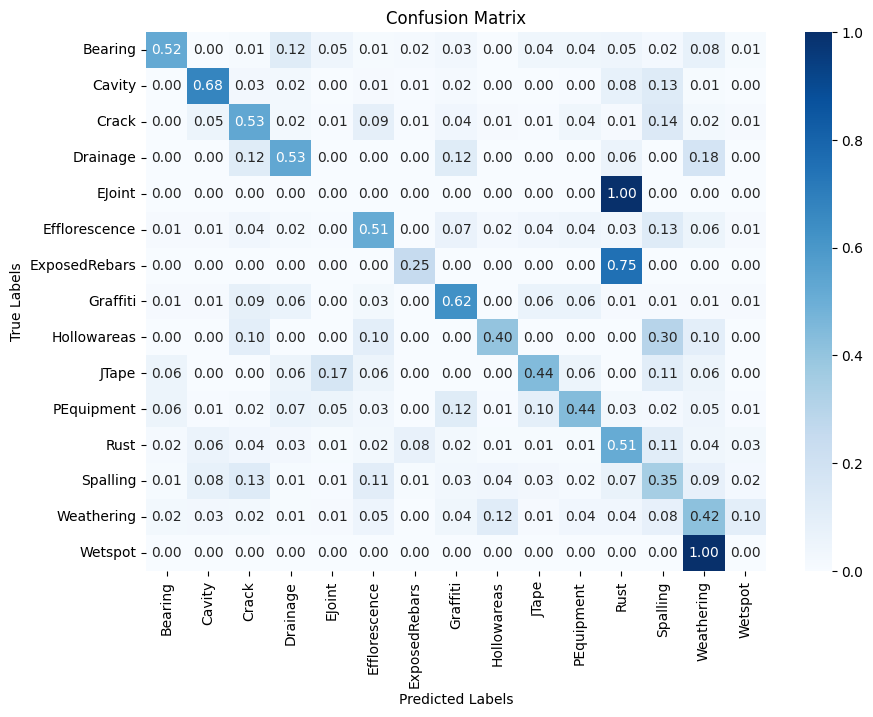

In [44]:
multilabel_classification = MultilabelClassificationModel()

# Meta-learning classification features: Analysis

**Analysis Rust**

In [14]:
# Create a classifier for rust:

rust_classifier = ClassificationModel("Rust")


Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7956510348441184, 
Recall: 0.8231929277171087,
F1: 0.8023314749113026



In [15]:
# Run classification on hypothesized features:

hypothesized_features_rust = ["reddish", "rough", "darker"] ## Insert hypothesized most relevant features here

rust_classifier.run(hypothesized_features_rust)


Feature set: ['reddish', 'rough', 'darker'], 
Accuracy: 0.766308619334556, 
Recall: 0.8148725949037962,
F1: 0.7784401390958768



(0.7784401390958768,
 reddish    0.723513
 rough      0.123546
 darker     0.152941
 dtype: float64)

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7956510348441184, 
Recall: 0.8231929277171087,
F1: 0.8023314749113026

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 

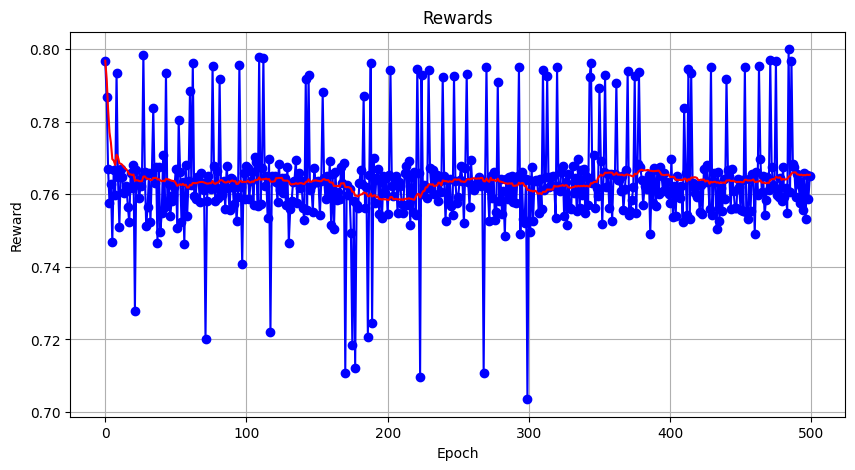

Best Feature set: ('gradient', 'reddish', 'black', 'dominating_color', 'color_bin_1', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_entropy', 'texture_0', 'texture_8', 'lengthy', 'number_lengthy_objects', 'rel_length', 'roundness', 'hu_moment_2', 'hu_moment_5')
Reward: 0.7999999999999999

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7956510348441184, 
Recall:

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [16]:
# Apply meta-learning and compare with random choices:

train_agent(rust_classifier, initial_features=hypothesized_features_rust, epochs=500)
#random_monkey(rust_classifier, repetitions=500)


**Analysis Drainage**

In [17]:
# Create a classifier for drainage:

drainage_classifier = ClassificationModel("Drainage")


Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7629255989911727, 
Recall: 0.7955112219451371,
F1: 0.7723970944309927



In [18]:
# Run classification on hypothesized features:

hypothesized_features_drainage = ["black", "black_thin", "metallic", "rough", "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", 
                                  "rel_length", "in_shape", "roundness"] ## Insert hypothesized most relevant features here

drainage_classifier.run(hypothesized_features_drainage)


Feature set: ['black', 'black_thin', 'metallic', 'rough', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness'], 
Accuracy: 0.725094577553594, 
Recall: 0.7281795511221946,
F1: 0.7281795511221947



(0.7281795511221947,
 black                     0.211439
 black_thin                0.161192
 metallic                  0.089672
 rough                     0.172890
 lengthy                   0.057379
 number_lengthy_objects    0.022614
 lengthy_aspect_ratio      0.032642
 rel_length                0.061746
 in_shape                  0.088137
 roundness                 0.102289
 dtype: float64)

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7629255989911727, 
Recall: 0.7955112219451371,
F1: 0.7723970944309927

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 

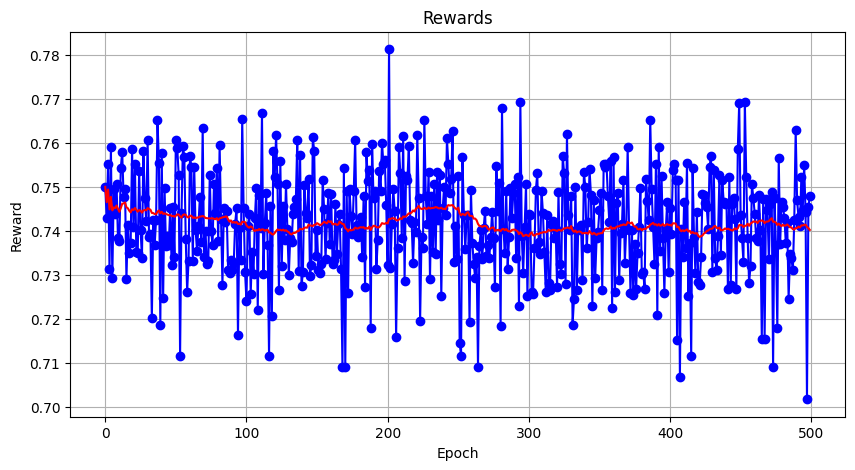

Best Feature set: ('gradient', 'colorful', 'black', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'texture_0', 'texture_1', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'lengthy', 'roundness', 'hu_moment_1', 'hu_moment_3', 'hu_moment_7')
Reward: 0.78125



In [19]:
# Apply meta-learning and compare with random choices:

train_agent(drainage_classifier, initial_features=hypothesized_features_drainage, epochs=500)
#random_monkey(drainage_classifier, repetitions=500)


**Analysis Graffiti**

In [20]:
# Create a classifier for graffiti:

graffiti_classifier = ClassificationModel("Graffiti")


Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7553191489361702, 
Recall: 0.7383820998278829,
F1: 0.7566137566137566



In [21]:
# Run classification on hypothesized features:

hypothesized_features_graffiti = ["colorful", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", 
                                  "hu_moment_5", "hu_moment_6", "hu_moment_7", "darker"] ## Insert hypothesized most relevant features here

graffiti_classifier.run(hypothesized_features_graffiti)


Feature set: ['colorful', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7', 'darker'], 
Accuracy: 0.6187943262411347, 
Recall: 0.6075731497418244,
F1: 0.6214788732394367



(0.6214788732394367,
 colorful       0.223688
 in_shape       0.151625
 roundness      0.121009
 hu_moment_1    0.050654
 hu_moment_2    0.048199
 hu_moment_3    0.049290
 hu_moment_4    0.048384
 hu_moment_5    0.029867
 hu_moment_6    0.043978
 hu_moment_7    0.036574
 darker         0.196732
 dtype: float64)

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'dominating_texture', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'in_shape', 'roundness', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7553191489361702, 
Recall: 0.7383820998278829,
F1: 0.7566137566137566

Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 

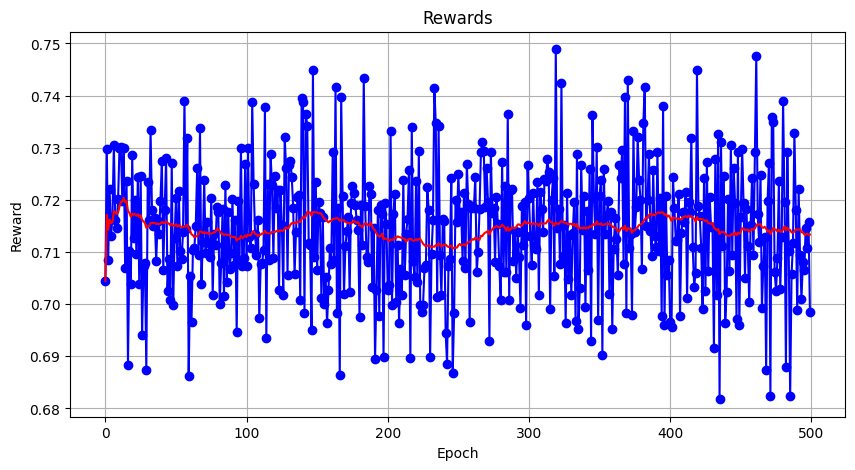

Best Feature set: ('darker', 'reddish', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_4', 'color_bin_6', 'color_bin_8', 'color_entropy', 'rough', 'dominating_texture', 'texture_1', 'texture_2', 'texture_4', 'texture_6', 'texture_7', 'texture_9', 'rough_entropy', 'lengthy', 'lengthy_aspect_ratio', 'roundness', 'hu_moment_4')
Reward: 0.748890860692103



In [22]:
# Apply meta-learning and compare with random choices:

train_agent(graffiti_classifier, initial_features=hypothesized_features_graffiti, epochs=500)
#random_monkey(graffiti_classifier, repetitions=500)
